In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import json

from config import Cfg as cfg

import mysql.connector

%matplotlib inline

# Results data

In [2]:
cnx = mysql.connector.connect(user=cfg.mysql_user, database=cfg.mysql_db, password=cfg.mysql_pw, ssl_disabled=True)

query = "SELECT * FROM results;"

# execute the query and assign it to a pandas dataframe
df_results = pd.read_sql(query, con=cnx)

cnx.close()

print("Number of single results:", len(df_results))
print("Number of individuals:", len(df_results.athlete.unique()))

Number of single results: 2000403
Number of individuals: 643055


# Races data

In [7]:
df_races = pd.read_csv('./../data/clean/races_features.csv', index_col='race')
len(df_races)

159

In [3]:
# cnx = mysql.connector.connect(user=cfg.mysql_user, database=cfg.mysql_db, password=cfg.mysql_pw, ssl_disabled=True)

# query = "SELECT * FROM races;"
# # execute the query and assign it to a pandas dataframe
# df_races = pd.read_sql(query, con=cnx)

# cnx.close()

# print("Number of single races:", len(df_races))

Number of single races: 220


### Some processing on the datasets

In [4]:
# # -----------
# # -- RACES --
# # -----------

# # keep only active races
# df_races = df_races.loc[df_races['info'].dropna().index]

# # remove duplicates
# df_races = df_races.loc[df_races.race != 'worldchampionship70.3m']

# # remove worldchampionship as it's by qualification so people cannot really choose to do it
# df_races = df_races.loc[df_races.race != 'worldchampionship70.3']
# df_races = df_races.loc[df_races.race != 'worldchampionship']

# # add Country codes
# with open("./../data/geo-data/races_geo_info.json", 'r') as f:
#     races_geo_info = json.loads(f.read())
             
# df_races['country_code'] = None
# for race in df_races.race.values:
#     country_code = races_geo_info[race]
#     df_races.loc[df_races.race == race, 'country_code'] = races_geo_info[race]['components']['ISO_3166-1_alpha-3']

# # Add location info
# races_locations = pd.read_csv("./../data/geo-data/races_lat_lon.csv")
# df_races = df_races.merge(races_locations, left_on = 'race', right_on = 'race', how = 'left')

# # Add info about type of race
# # saving the races references for index
# df_races['is_70.3'] = df_races['race'].str.contains('70.3')

# # keep only columns of interest
# df_races = df_races[['race', 'racename', 'is_70.3', 'region', 'country_code', 'lat', 'lon']]

# # make the index the race name
# df_races = df_races.set_index('race')

# print("Number of single races:", len(df_races))

Number of single races: 157


In [8]:
# -----------
# -- RESULTS --
# -----------

# worldchampionship70.3 and worldchampionship70.3m are the same race
df_results.loc[df_results.race == "worldchampionship70.3m", 'race'] = 'worldchampionship70.3'

# keep only results of non discontinued races
df_results = df_results[df_results['race'].isin(df_races.index)]

# extract gender from division
df_results['gender'] = df_results['division'].apply(lambda x: x[0])

# convert date to datetime
df_results['date'] = pd.to_datetime(df_results['date'])

# str to int
df_results['year'] = df_results['year'].apply(int)

# keep only results from after 2015
df_results = df_results.loc[df_results['year'] >= 2015]

# # discard pro athletes
# df_results = df_results.loc[df_results.division.str.contains("PRO") == False]

# Add gender
df_results['gender'] = None
df_results.loc[df_results['division'].str.contains("M"), 'gender'] = "M"
df_results.loc[df_results['division'].str.contains("F"), 'gender'] = "F"


print("Number of remaining single results:", len(df_results))
print("Number of remaining individuals:", len(df_results.athlete.unique()))
print("Number of races in results df:", len(df_results.race.unique()))

Number of remaining single results: 969046
Number of remaining individuals: 400032
Number of races in results df: 158


# Filter results dataset to keep only prolific racers
#### To prevent cold-start problem keep only people with at least 3 different races.

In [9]:
min_unique_race_count = 4

# total number of races per athlete
athletes_count_races = (df_results.groupby('athlete')['division']
     .size()
     .reset_index()
     .rename(columns={'division': 'n_races'})
)

# total number of different races per athlete
athletes_count_diff_races = (df_results
     .groupby(['athlete', 'race'])
     .size()
     .reset_index()
     .groupby('athlete')
     .size()
     .reset_index()
     .rename(columns={0: 'n_different_races'})
)

# merge the two so we can filter from that
athlete_habits = athletes_count_diff_races.merge(athletes_count_races, left_on="athlete", right_on="athlete", how="left")

# What we are filtering with
max_count_races = 100 # probably similar names

valid_athletes = athlete_habits.loc[(athlete_habits['n_different_races']>=min_unique_race_count) & (athlete_habits['n_races']<=max_count_races)]

# use this df to filter original results data
df_results_filtered = df_results.loc[df_results['athlete'].isin(valid_athletes['athlete'])]
df_results_filtered = df_results_filtered.merge(valid_athletes, left_on="athlete", right_on="athlete", how="left")

# Anonimize entrants
user_hash = {}

for i,user in enumerate(df_results_filtered.athlete.unique()):
    user_hash[user] = f'u{i}'
df_results_filtered.loc[:, 'athlete'] = df_results_filtered.athlete.map(lambda x: user_hash[x])

print("Number of valid individuals:", len(valid_athletes))
print("Number of remaining single results:", len(df_results_filtered))
print("Number of races present in filtered results:", len(df_results_filtered.race.unique()))

Number of valid individuals: 48895
Number of remaining single results: 360158
Number of races present in filtered results: 158


### Update races df to only keep races present in filtered results df

In [11]:
df_races_for_model = df_races.loc[df_results_filtered.race.unique()]
print("Number of remaining races:", len(df_races_for_model))

Number of remaining races: 158


# Create dataframe with race count per athlete

In [12]:
results_races_count = (
    df_results_filtered
        .groupby(['athlete', 'race'])
        .size()
        .reset_index()
        .rename(columns={0: 'count'})
)

# Add demographics info for users (if we want to filter later)
gender = (df_results_filtered
     .groupby(['athlete', 'gender'])
     .size()
     .reset_index()
     .rename(columns={0: 'n'})
     .pivot(index='athlete', columns='gender', values='n')
     .idxmax(axis=1)
     .rename('gender')
)

country = (df_results_filtered
     .groupby(['athlete', 'country'])
     .size()
     .reset_index()
     .rename(columns={0: 'n'})
     .pivot(index='athlete', columns='country', values='n')
     .idxmax(axis=1)
     .rename('country')
)

results_races_count = results_races_count.merge(gender, left_on = 'athlete', right_on = 'athlete', how = 'left')
results_races_count = results_races_count.merge(country, left_on = 'athlete', right_on = 'athlete', how = 'left')

results_races_count.head()

,athlete,race,count,gender,country
0,u0,cozumel,1,M,USA
1,u0,liuzhou70.3,1,M,USA
2,u0,mardelplata,1,M,USA
3,u0,newzealand,1,M,USA
4,u0,worldchampionship,3,M,USA


# Recommender class

In [14]:
class BaseRecommender:
    def __init__(self, model, matrix, items_info, name='Model'):
        self.name = name
        self.model = model
        self.matrix = matrix
        self.items_info = items_info
        self.items_info_reset = items_info.reset_index()
        

class ALSRecommender(BaseRecommender):
     def recommend(self, target, n=10, filterByField=False, valueToMatch=False):
        target_code = self.items_info.index.get_loc(target)
        similar = self.model.similar_items(target_code, len(self.items_info))
        
        df_distances = pd.DataFrame([
                [self.items_info_reset.loc[code, 'race'], distance] for (code,distance) in similar
            ], columns=['race', 'distance'])
        
        df_order = df_distances.merge(self.items_info, left_on='race', right_on='race', how='left')
        if filterByField:
            df_order = df_order.loc[df_order[filterByField] == valueToMatch]

        return df_order


# Alternative Least Square (ALS)

The data we have are implicit data (data gathered from the users behaviour, with no ratings or specific actions needed. It could be what items a user purchased, how many times they played a song or watched a movie, how long they’ve spent reading a specific article etc. The upside is that we have a lot more of this data, the downside is that it’s more noisy and not always apparent what it means.)

ALS has been developped specifically for implicit data

## Prepare data

In [25]:
import scipy.sparse as sparse

full_set = results_races_count.copy()
full_set_pivot = full_set.pivot(index='race', columns='athlete', values='count').fillna(0)
sparse_item_user = sparse.csr_matrix(full_set_pivot.values)

filename_base = './../flask_app/nostrappdamus/model/data'

# save the matrix to disk
sparse.save_npz(f'{filename_base}/als_sparse_matrix.npz', sparse_item_user)

# save order of races used
with open(f'{filename_base}/als_hash.json', 'w') as f:
    race_hash = df_races_for_model.loc[full_set_pivot.index].reset_index()['race'].to_dict()
    f.write(json.dumps(race_hash))

print("Matrix size:", sparse_item_user.shape)

Matrix size: (158, 48895)


In [29]:
# list(race_hash.values())
# hash_race_to_code = dict((v,int(k)) for k,v in hash_code_to_race.items())

In [10]:
# import scipy.sparse as sparse

# full_set = results_races_count.copy()

# # Converting the numbers to categories to be used for creating the categorical codes to avoid using long hash keys 
# full_set['athlete'] = full_set['athlete'].astype("category")
# full_set['race'] = full_set['race'].astype("category")

# #cat.codes creates a categorical id for the users and artists
# full_set['athlete_id'] = full_set['athlete'].cat.codes
# full_set['race_id'] = full_set['race'].cat.codes

# # create dict of races categories for later mapping
# races_cat = dict( enumerate(full_set['race'].cat.categories ) )

# # The implicit library expects data as a item-user matrix so we
# # create two matrices, one for fitting the model (item-user) 
# # and one for recommendations (user-item)

# sparse_item_user = sparse.csr_matrix((full_set['count'].astype(float), (full_set['race_id'], full_set['athlete_id'])))

### Sparcity of the matrix

In [30]:
matrix_size = sparse_item_user.shape[0]*sparse_item_user.shape[1] # Number of possible interactions in the matrix
num_raced = len(sparse_item_user.nonzero()[0]) # Number of items interacted with
sparsity = (1 - (num_raced/matrix_size))
sparsity

0.9636038734513767

In [31]:
from implicit.evaluation import precision_at_k, mean_average_precision_at_k, train_test_split #, ndcg_at_k
from implicit.als import AlternatingLeastSquares
from implicit.bpr import BayesianPersonalizedRanking
from implicit.nearest_neighbours import (BM25Recommender, CosineRecommender,
                                         TFIDFRecommender, bm25_weight)

train, test = train_test_split(sparse_item_user, train_percentage=0.8)

In [32]:
models = {
    'als': AlternatingLeastSquares(factors=20, regularization=0.1, iterations=50), 
    'bpr': BayesianPersonalizedRanking(factors=20, regularization=0.1, iterations=50), 
    'cosine': CosineRecommender(K=20)
}

# Calculate the confidence by multiplying it by our alpha value.(alpha value corresponds to the confidence metric 
# that we discussed earlier)
alpha = 30
train_conf = (train * alpha).astype('double')
        
for model in models:
    if model == 'als':
        models[model].fit(train_conf)
    else:
        models[model].fit(train)

100%|██████████| 50.0/50 [00:08<00:00,  6.11it/s]
100%|██████████| 158/158 [00:00<00:00, 49935.95it/s]


In [33]:
for model in models:
    p1 = precision_at_k(models[model], train.T.tocsr(), test.T.tocsr(), K=10, num_threads=4)
    p2 = mean_average_precision_at_k(models[model], train.T.tocsr(), test.T.tocsr(), K=10, num_threads=4)
    print(f"Model {model}:")
    print(f"p@10: {p1}\nmap@10: {p2}")

  3%|▎         | 1233/48895 [00:00<00:04, 11873.37it/s]

Model als:
p@10: 0.49247494599667124
map@10: 0.25132964425817417


  7%|▋         | 3203/48895 [00:00<00:01, 31818.47it/s]

Model bpr:
p@10: 0.09221289705726124
map@10: 0.03542727914929211


100%|██████████| 48895/48895 [00:01<00:00, 37647.77it/s]

Model cosine:
p@10: 0.5481072275930451
map@10: 0.28818451473351386


In [39]:
from sklearn.model_selection import ParameterGrid

param_grid = {
    'confidence_factor': [1, 5, 10, 20, 30, 40], 
    'als__factors': [5, 8, 10, 13, 17, 21, 25, 30],
    'als__regularization': [1e-1, 1e-2, 1e-3, 1e-4]
}

params_combinations = list(ParameterGrid(param_grid))


als_evaluation = {}

for i,params in enumerate(params_combinations):
    train_conf = (train * params['confidence_factor']).astype('double')
    model = AlternatingLeastSquares(factors=params['als__factors'], regularization=params['als__regularization'], iterations=50)
    model.fit(train_conf)
    
    map5 = mean_average_precision_at_k(model, train.T.tocsr(), test.T.tocsr(), K=5, num_threads=4)
    map10 = mean_average_precision_at_k(model, train.T.tocsr(), test.T.tocsr(), K=10, num_threads=4)
    
    als_evaluation[i] = {
        'map@5': map5,
        'map@10': map10
    } 

In [38]:
len(params_combinations)

192

In [44]:
evaluation_results = pd.DataFrame([
    [params_combinations[i]['confidence_factor'], 
    params_combinations[i]['als__factors'],
    params_combinations[i]['als__regularization'], 
    als_evaluation[i]['map@5'], 
    als_evaluation[i]['map@10']] 
    for i in range(len(params_combinations))
], columns=['confidence', 'n_factors', 'regularization', 'map@5', 'map@10'])

evaluation_results.to_csv('figs/als_hyperparameters_tuning.csv', index=False)

In [52]:
evaluation_results.loc[evaluation_results['map@5'] == evaluation_results['map@5'].max()]

,confidence,n_factors,regularization,map@5,map@10
103,5,17,0.01,0.232005,0.258741


In [54]:
evaluation_results.loc[evaluation_results['map@10'] == evaluation_results['map@10'].max()]

,confidence,n_factors,regularization,map@5,map@10
103,5,17,0.01,0.232005,0.258741


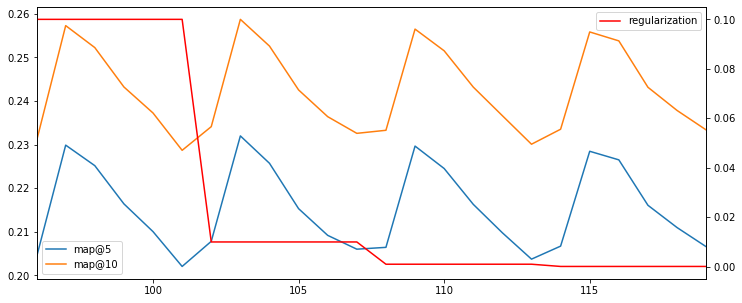

In [62]:
fig,ax = plt.subplots(figsize=(12, 5))
ax1 = ax.twinx()
evaluation_results.loc[evaluation_results.n_factors == 17, ['map@5', 'map@10']].plot(ax=ax)
evaluation_results.loc[evaluation_results.n_factors == 17, ['regularization']].plot(ax=ax1, c='r')
# evaluation_results.loc[evaluation_results.n_factors == 17, ['n_factors']].plot(ax=ax1)

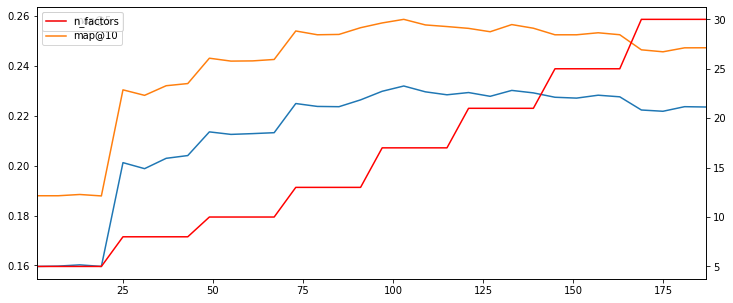

In [63]:
fig,ax = plt.subplots(figsize=(12, 5))
ax1 = ax.twinx()
evaluation_results.loc[evaluation_results.confidence == 5, ['map@5', 'map@10']].plot(ax=ax)
evaluation_results.loc[evaluation_results.confidence == 5, ['n_factors']].plot(ax=ax1, c='r')
# evaluation_results.loc[evaluation_results.n_factors == 17, ['n_factors']].plot(ax=ax1)

In [42]:
# let's refine

param_grid2 = {
    'confidence_factor': np.arange(2, 10, 0.5), 
    'als__factors': range(16, 20),
    'als__regularization': [1e-2]
}

params_combinations2 = list(ParameterGrid(param_grid2))


als_evaluation2 = {}

for i,params in enumerate(params_combinations2):
    train_conf = (train * params['confidence_factor']).astype('double')
    model = AlternatingLeastSquares(factors=params['als__factors'], regularization=params['als__regularization'], iterations=50)
    model.fit(train_conf)
    
    map5 = mean_average_precision_at_k(model, train.T.tocsr(), test.T.tocsr(), K=5, num_threads=4)
#     map10 = mean_average_precision_at_k(model, train.T.tocsr(), test.T.tocsr(), K=10, num_threads=4)
    
    als_evaluation2[i] = {
        'map@5': map5,
#         'map@10': map10
    } 

100%|██████████| 50.0/50 [00:07<00:00,  6.99it/s]
100%|██████████| 45799/45799 [00:03<00:00, 12128.02it/s]
100%|██████████| 50.0/50 [00:07<00:00,  6.72it/s]
100%|██████████| 45799/45799 [00:03<00:00, 12257.55it/s]
100%|██████████| 50.0/50 [00:07<00:00,  6.52it/s]
100%|██████████| 45799/45799 [00:04<00:00, 11443.80it/s]
100%|██████████| 50.0/50 [00:07<00:00,  6.41it/s]
100%|██████████| 45799/45799 [00:03<00:00, 11727.32it/s]
100%|██████████| 50.0/50 [00:07<00:00,  6.31it/s]
100%|██████████| 45799/45799 [00:03<00:00, 11829.32it/s]
100%|██████████| 50.0/50 [00:08<00:00,  6.22it/s]
100%|██████████| 45799/45799 [00:04<00:00, 10587.93it/s]
100%|██████████| 50.0/50 [00:07<00:00,  6.27it/s]
100%|██████████| 45799/45799 [00:04<00:00, 11336.69it/s]
100%|██████████| 50.0/50 [00:08<00:00,  6.25it/s]
100%|██████████| 45799/45799 [00:03<00:00, 12403.62it/s]
100%|██████████| 50.0/50 [00:07<00:00,  6.26it/s]
100%|██████████| 45799/45799 [00:03<00:00, 11926.46it/s]
100%|██████████| 50.0/50 [00:07<00:00

In [45]:
evaluation_results2 = pd.DataFrame([
    [params_combinations2[i]['confidence_factor'], 
    params_combinations2[i]['als__factors'],
    params_combinations2[i]['als__regularization'], 
    als_evaluation2[i]['map@5']]
#     als_evaluation2[i]['map@10']] 
    for i in range(len(params_combinations2))
], columns=['confidence', 'n_factors', 'regularization', 'map@5'])

# evaluation_results2.to_csv('figs/als_hyperparameters_tuning-fine.csv', index=False)

In [46]:
# Best params
evaluation_results2.loc[evaluation_results2['map@5'] == evaluation_results2['map@5'].max()]

,confidence,n_factors,regularization,map@5
55,5.5,19,0.01,0.242647


In [34]:
best_params = {
    'confidence': 6.5,
    'regularization': 0.01,
    'n_factors': 16
}

best_params = {
    'confidence': 5.5,
    'regularization': 0.01,
    'n_factors': 19
}

full_set_conf = (sparse_item_user * best_params['confidence']).astype('double')

als_final = AlternatingLeastSquares(factors=best_params['n_factors'], regularization=best_params['regularization'], iterations=50)
als_final.fit(full_set_conf)


100%|██████████| 50.0/50 [00:08<00:00,  5.66it/s]


In [48]:
mean_average_precision_at_k(als_final, train.T.tocsr(), test.T.tocsr(), K=5, num_threads=4)

100%|██████████| 45799/45799 [00:04<00:00, 10309.28it/s]


0.5120637497833398

In [35]:
import pickle

# save the model to disk
filename_base = './../flask_app/nostrappdamus/model/data'
pickle.dump(als_final, open(f"{filename_base}/als_model.sav", 'wb'))



# # save the races/codes hash
# with open(f"{filename_base}/als_race_hash.json", "w") as f:
#     f.write(json.dumps(races_cat))


In [91]:
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(f"{filename_base}/als-model.sav", 'rb'))
loaded_matrix = sparse.load_npz(f"{filename_base}/als_sparse_matrix.npz")
with open(f"{filename_base}/als_race_hash.json", "r") as f:
    hash_code_to_race = json.loads(f.read())

hash_race_to_code = dict((v,int(k)) for k,v in hash_code_to_race.items())
    
query = 'france70.3'
code_query = hash_race_to_code[query]

similar = loaded_model.similar_items(code_query, 10)

for code,distance in similar:
    print(hash_code_to_race[f'{code}'], distance)

france70.3 0.20848429
vichy70.3 0.20397756
Nice70.3 0.20325567
france 0.16773026
vichy 0.15156436
lanzarote70.3 0.14225355
barcelona70.3 0.13950655
luxembourg70.3 0.13868877
switzerland70.3 0.12784839
marbella70.3 0.11253704


In [162]:
cosine = CosineRecommender(K=30)
cosine.fit(sparse_item_user)
mean_average_precision_at_k(cosine, train.T.tocsr(), test.T.tocsr(), K=5, num_threads=4)
# pd.DataFrame([[hash_code_to_race[f'{code}'],distance] for i,(code,distance) in enumerate(similar) if i>0], columns=['race', 'distance'])

100%|██████████| 82912/82912 [00:01<00:00, 42394.77it/s]


0.27641541442882595

### Example for recommendation

In [121]:
class ALSrecommender:
    def __init__(self, full_set, train_set=None, items_info_df=None, name="ALS model"):
        self.name = name
        self.full_set = full_set
        self.train_set = train_set if type(train_set) != type(None) else full_set
        self.items_df = self.train_set.reset_index()[['athlete', 'race', 'count']]
        # Converting the numbers to categories to be used for creating the categorical codes to avoid using long hash keys 
        self.items_df['athlete'] = self.items_df['athlete'].astype("category")
        self.items_df['race'] = self.items_df['race'].astype("category")
        #cat.codes creates a categorical id for the users and artists
        self.items_df['athlete_id'] = self.items_df['athlete'].cat.codes
        self.items_df['race_id'] = self.items_df['race'].cat.codes
        # The implicit library expects data as a item-user matrix so we
        # create two matrices, one for fitting the model (item-user) 
        # and one for recommendations (user-item)
        self.items_matrix = csr_matrix((self.items_df['count'].astype(float), (self.items_df['race_id'], self.items_df['athlete_id'])))
        # make sure the items_info_df has the same order than the items_df
        if type(items_info_df) == type(None):
            self.items_info_df = self.items_df[['race', 'race_id']].drop_duplicates()
            self.items_info_df = self.items_info_df.set_index('race')
        else:
            self.items_info_df = items_info_df.merge(self.items_df[['race', 'race_id']].drop_duplicates(), left_on='race', right_on='race', how='left')
            self.items_info_df = self.items_info_df.set_index('race')
            
    def make_model(self, factors=20, regularization=0.1, iterations=40, alpha=15):
        # Initialize the als model and fit it using the sparse item-user matrix
        # Parameters that we have chosen
        # 1. factors = 20 -- Latent factors for user and item vectors
        # 2. iterations = 20 -- Number of iterations to use while fitting the data
        # 3. regularization = 0.1 -- regularization constant to be used in the cost function

        self.model = implicit.als.AlternatingLeastSquares(factors=factors, regularization=regularization, iterations=iterations)

        # Calculate the confidence by multiplying it by our alpha value.(alpha value corresponds to the confidence metric 
        # that we discussed earlier)
        data_conf = (self.items_matrix * alpha).astype('double')

        # We have used an alpha_val of 15 after performing some iterations with different alpha values
        #Fit the model
        self.model.fit(data_conf)
        
    def recommend(self, similarTo, topn=10):
        # get encoded categorical id of race
        race_id = self.items_info_df.loc[similarTo]['race_id']

        # Use implicit to get similar items.
        similar = self.model.similar_items(race_id, topn+1)[1:]
        out_distances = list(map(lambda x: x[1], similar))
        out_races = list(map(lambda x: self.items_info_df.loc[self.items_info_df['race_id'] == x[0]].index.values[0], similar))
        
        out_df = self.items_info_df.loc[out_races]
        out_df['similarity'] = out_distances

        return out_df

In [122]:
als_model = ALSrecommender(full_set, train_set, items_info_df=df_races, name=f'ALS model')
als_model.make_model(factors=20, regularization=0.1, iterations=40, alpha=15)                      


100%|██████████| 40.0/40 [00:38<00:00,  1.05it/s]


In [124]:
# als_model.items_info_df['race' = als_model.items_info_df.index
als_model.recommend('france70.3', 10)

,racename,is_70.3,region,country_code,lat,lon,race_id,similarity
race,,,,,,,,
vichy70.3,IRONMAN 70.3 Vichy,True,Europe,FRA,46.128845,3.414791,146,0.432532
Nice70.3,IRONMAN 70.3 Nice,True,Europe,FRA,43.684918,7.241314,7,0.418482
barcelona70.3,IRONMAN 70.3 Barcelona,True,Europe,ESP,41.615767,2.671412,20,0.378834
vichy,IRONMAN Vichy,False,Europe,FRA,46.128894,3.414719,145,0.290592
luxembourg70.3,IRONMAN 70.3 Luxembourg - Région Moselle,True,Europe,LUX,49.551630,6.376436,87,0.262203
switzerland70.3,IRONMAN 70.3 Switzerland,True,Europe,CHE,47.222923,8.830523,133,0.243498
france,IRONMAN France,False,Europe,FRA,43.684857,7.241084,58,0.206520
chattanooga,IRONMAN Chattanooga,False,North America,USA,35.063181,-85.287417,40,0.184227
mallorca70.3,IRONMAN 70.3 Mallorca,True,Europe,ESP,39.836211,3.124180,90,0.176119


## Evaluating the model

We'll use the **Mean Average Precision** at **K**

In [125]:
from utils.average_precision import mapk

In [126]:
class ModelEvaluator:
    def __init__(self, full_set, train_set, test_set, size):
        self.full_set = full_set
        self.train_set = train_set
        self.test_set = test_set
        self.requested_size = size
        self.users_sample = self.get_users_sample(n=size)
        self.users_interacted_items_in_train = [self.get_interacted_items_for_from(userId, self.train_set) for userId in self.users_sample]
        self.users_picked_race = [np.random.choice(races_in_train) for races_in_train in self.users_interacted_items_in_train]
        self.users_interacted_items_in_test = [self.get_interacted_items_for_from(userId, self.test_set) for userId in self.users_sample]

    @staticmethod
    def get_interacted_items_for_from(userId, dataset):
        interacted_items = dataset.loc[userId, 'race']
        return interacted_items.tolist() if type(interacted_items) == pd.Series else [interacted_items]
    
    def get_users_sample(self, n):
        return list(np.random.choice(np.unique(self.full_set.index), size=n, replace=False))

In [127]:
# let's test our model on 10000 randomly picked athletes
evaluator = ModelEvaluator(full_set, train_set, test_set, 2000)

In [128]:
# we'll create a popularity model that will output the most popular races
popularity = train_set.reset_index().groupby('race')['count'].sum().sort_values(ascending=False).reset_index()
popularity = popularity.set_index('race')

class PopularityModel:
    def __init__(self, popularity, name='popularity'):
        self.name = name
        self.popularity = popularity
        
    def recommend(self, race, n):
        return self.popularity.iloc[:n]
    
popularity_model = PopularityModel(popularity)

In [142]:
results = {}

# fit models on train set
knn_binary = KNNrecommender(full_set, train_set, binary=True, items_info_df=df_races, name='KNN binary')
knn_binary.make_model(metric='cosine', algorithm='brute', n_neighbors=5)
knn_count = KNNrecommender(full_set, train_set, binary=False, items_info_df=df_races, name='KNN count')
knn_count.make_model(metric='cosine', algorithm='brute', n_neighbors=5)
lsh_256 = LSHrecommender(full_set, train_set, items_info_df=df_races, name='LSH model 256')
lsh_256.make_model(256)
lsh_512 = LSHrecommender(full_set, train_set, items_info_df=df_races, name='LSH model 512')
lsh_512.make_model(512)
knn_svd = KNNrecommender(full_set, train_set, binary=False, items_info_df=df_races, name=f'KNN SVD 21')
knn_svd.make_model(metric='cosine', algorithm='brute', n_neighbors=5, model_type='SVD', n_components=21)
als_model = ALSrecommender(full_set, train_set, items_info_df=df_races, name=f'ALS model')
als_model.make_model(factors=10, regularization=0.1, iterations=50, alpha=20)
                         
# models list
models_to_test = [popularity_model, knn_count, knn_binary, lsh_256, lsh_512, lsh_1024, knn_svd, als_model] 
    
for model in models_to_test:
    # make recommendation
    races_recommended = [model.recommend(race, 20).index.tolist() for race in evaluator.users_picked_race]
    mapk_5_10_20 = [mapk(evaluator.users_interacted_items_in_test, races_recommended, k) for k in [5, 10, 20]]
    
    # store results
    results[model.name] = mapk_5_10_20
    print(f"Recommendations with the {model.name} model done!")
    
evaluation_results_df = pd.DataFrame(results, index=['MAP@5', 'MAP@10', 'MAP@20']).transpose()

100%|██████████| 50.0/50 [00:31<00:00,  1.58it/s]


Recommendations with the popularity model done!
Recommendations with the KNN count model done!
Recommendations with the KNN binary model done!
Recommendations with the LSH model 256 model done!
Recommendations with the LSH model 512 model done!
Recommendations with the LSH model 1024 model done!
Recommendations with the KNN SVD 21 model done!
Recommendations with the ALS model model done!


In [143]:
evaluation_results_df

,MAP@5,MAP@10,MAP@20
popularity,0.060266,0.074134,0.085532
KNN count,0.119841,0.143131,0.158821
KNN binary,0.129905,0.152196,0.168234
LSH model 256,0.044489,0.056453,0.067137
LSH model 512,0.039171,0.051894,0.062050
LSH model 1024,0.045889,0.059048,0.069150
KNN SVD 21,0.080650,0.097464,0.111622
ALS model,0.095047,0.111712,0.122204


In [145]:
als_model.model

In [147]:
import pickle
# save the model to disk
filename = './als-model.sav'
pickle.dump(als_model.model, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.recommen(X_test, Y_test)

race_id = als_model.items_info_df.loc['france70.3']['race_id']

# Use implicit to get similar items.
similar = loaded_model.similar_items(race_id, 10)
similar

In [148]:
race_id = als_model.items_info_df.loc['france70.3']['race_id']

# Use implicit to get similar items.
similar = loaded_model.similar_items(race_id, 10)
similar

[(59, 0.3313097),
 (146, 0.3205595),
 (7, 0.3160128),
 (68, 0.2845827),
 (20, 0.2766896),
 (87, 0.2600407),
 (133, 0.25081438),
 (90, 0.24584988),
 (80, 0.24344717),
 (1, 0.23501675)]

### ALS number of factors

In [135]:
results = {}

models_to_test = []

for i in range(5, 51, 3):
    # fit models on train set
    als_model = ALSrecommender(full_set, train_set, items_info_df=df_races, name=f'ALS model {i}')
    als_model.make_model(factors=i, regularization=0.1, iterations=40, alpha=15)
    models_to_test.append(als_model)
     
for model in models_to_test:
    # make recommendation
    races_recommended = [model.recommend(race, 20).index.tolist() for race in evaluator.users_picked_race]
    mapk_5_10_20 = [mapk(evaluator.users_interacted_items_in_test, races_recommended, k) for k in [5, 10, 20]]
    
    # store results
    results[model.name] = mapk_5_10_20
    print(f"Recommendations with the {model.name} model done!")
    
evaluation_results_df = pd.DataFrame(results, index=['MAP@5', 'MAP@10', 'MAP@20']).transpose()

100%|██████████| 40.0/40 [00:18<00:00,  2.21it/s]
100%|██████████| 40.0/40 [00:20<00:00,  1.94it/s]
100%|██████████| 40.0/40 [00:28<00:00,  1.42it/s]
100%|██████████| 40.0/40 [00:29<00:00,  1.36it/s]
100%|██████████| 40.0/40 [00:39<00:00,  1.01it/s]
100%|██████████| 40.0/40 [00:41<00:00,  1.03s/it]
100%|██████████| 40.0/40 [00:41<00:00,  1.04s/it]
100%|██████████| 40.0/40 [00:50<00:00,  1.15s/it]
100%|██████████| 40.0/40 [00:55<00:00,  1.16s/it]
100%|██████████| 40.0/40 [00:45<00:00,  1.14s/it]
100%|██████████| 40.0/40 [00:46<00:00,  1.16s/it]
100%|██████████| 40.0/40 [00:52<00:00,  1.32s/it]
100%|██████████| 40.0/40 [01:02<00:00,  1.55s/it]
100%|██████████| 40.0/40 [00:51<00:00,  1.30s/it]
100%|██████████| 40.0/40 [00:53<00:00,  1.15s/it]
100%|██████████| 40.0/40 [00:55<00:00,  1.15s/it]


Recommendations with the ALS model 5 model done!
Recommendations with the ALS model 8 model done!
Recommendations with the ALS model 11 model done!
Recommendations with the ALS model 14 model done!
Recommendations with the ALS model 17 model done!
Recommendations with the ALS model 20 model done!
Recommendations with the ALS model 23 model done!
Recommendations with the ALS model 26 model done!
Recommendations with the ALS model 29 model done!
Recommendations with the ALS model 32 model done!
Recommendations with the ALS model 35 model done!
Recommendations with the ALS model 38 model done!
Recommendations with the ALS model 41 model done!
Recommendations with the ALS model 44 model done!
Recommendations with the ALS model 47 model done!
Recommendations with the ALS model 50 model done!


In [136]:
evaluation_results_df

,MAP@5,MAP@10,MAP@20
ALS model 5,0.086874,0.104690,0.119181
ALS model 8,0.095591,0.113382,0.126563
ALS model 11,0.096892,0.110777,0.121828
ALS model 14,0.087826,0.102128,0.111982
ALS model 17,0.083371,0.096332,0.105589
ALS model 20,0.077628,0.091350,0.099722
ALS model 23,0.068394,0.079580,0.087660
ALS model 26,0.070105,0.081754,0.089555
ALS model 29,0.064385,0.074700,0.082867
ALS model 32,0.059330,0.068765,0.075889


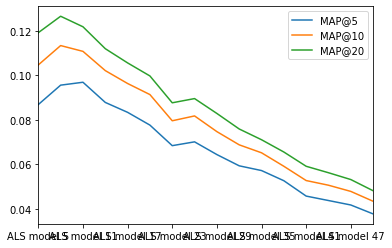

In [137]:
evaluation_results_df.plot()

### ALS confidence alpha

In [140]:
results = {}

models_to_test = []

for i in range(15, 31, 1):
    # fit models on train set
    als_model = ALSrecommender(full_set, train_set, items_info_df=df_races, name=f'ALS alpha {i}')
    als_model.make_model(factors=10, regularization=0.1, iterations=40, alpha=i)
    models_to_test.append(als_model)
     
for model in models_to_test:
    # make recommendation
    races_recommended = [model.recommend(race, 20).index.tolist() for race in evaluator.users_picked_race]
    mapk_5_10_20 = [mapk(evaluator.users_interacted_items_in_test, races_recommended, k) for k in [5, 10, 20]]
    
    # store results
    results[model.name] = mapk_5_10_20
    print(f"Recommendations with the {model.name} model done!")
    
evaluation_results_df = pd.DataFrame(results, index=['MAP@5', 'MAP@10', 'MAP@20']).transpose()

100%|██████████| 40.0/40 [00:28<00:00,  1.41it/s]
100%|██████████| 40.0/40 [00:26<00:00,  1.48it/s]
100%|██████████| 40.0/40 [00:27<00:00,  1.45it/s]
100%|██████████| 40.0/40 [00:25<00:00,  1.56it/s]
100%|██████████| 40.0/40 [00:25<00:00,  1.57it/s]
100%|██████████| 40.0/40 [00:25<00:00,  1.58it/s]
100%|██████████| 40.0/40 [00:25<00:00,  1.57it/s]
100%|██████████| 40.0/40 [00:25<00:00,  1.58it/s]
100%|██████████| 40.0/40 [00:26<00:00,  1.51it/s]
100%|██████████| 40.0/40 [00:26<00:00,  1.51it/s]
100%|██████████| 40.0/40 [00:26<00:00,  1.52it/s]
100%|██████████| 40.0/40 [00:26<00:00,  1.52it/s]
100%|██████████| 40.0/40 [00:27<00:00,  1.47it/s]
100%|██████████| 40.0/40 [00:28<00:00,  1.41it/s]
100%|██████████| 40.0/40 [00:27<00:00,  1.46it/s]
100%|██████████| 40.0/40 [00:27<00:00,  1.48it/s]


Recommendations with the ALS alpha 15 model done!
Recommendations with the ALS alpha 16 model done!
Recommendations with the ALS alpha 17 model done!
Recommendations with the ALS alpha 18 model done!
Recommendations with the ALS alpha 19 model done!
Recommendations with the ALS alpha 20 model done!
Recommendations with the ALS alpha 21 model done!
Recommendations with the ALS alpha 22 model done!
Recommendations with the ALS alpha 23 model done!
Recommendations with the ALS alpha 24 model done!
Recommendations with the ALS alpha 25 model done!
Recommendations with the ALS alpha 26 model done!
Recommendations with the ALS alpha 27 model done!
Recommendations with the ALS alpha 28 model done!
Recommendations with the ALS alpha 29 model done!
Recommendations with the ALS alpha 30 model done!
